<a href="https://colab.research.google.com/github/CamdenBert/CSCI290/blob/main/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

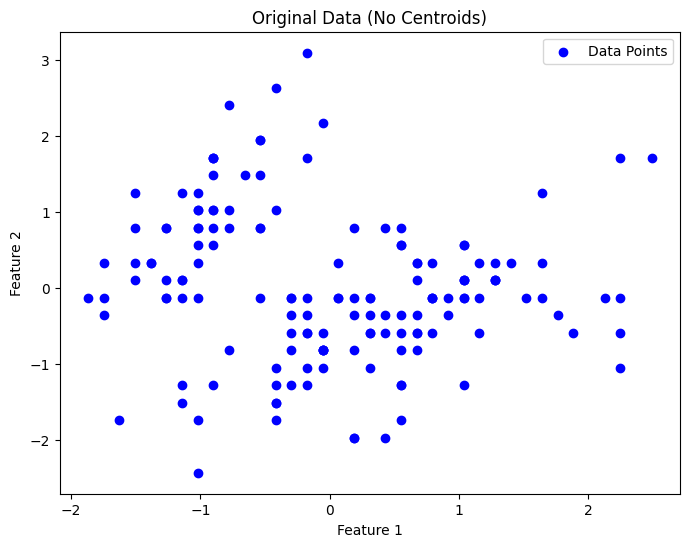

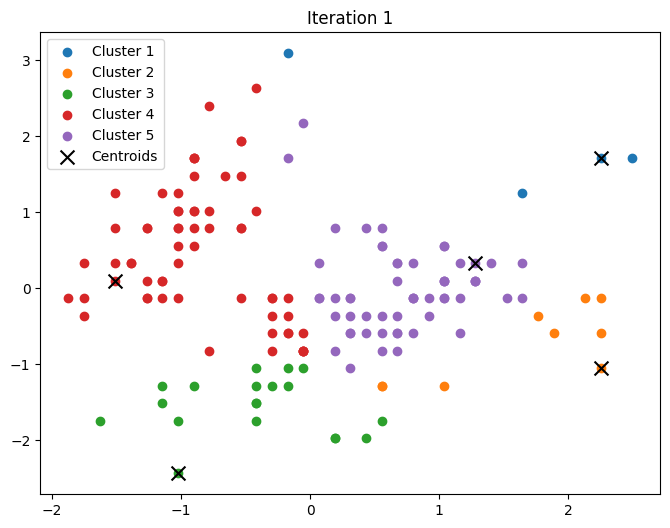

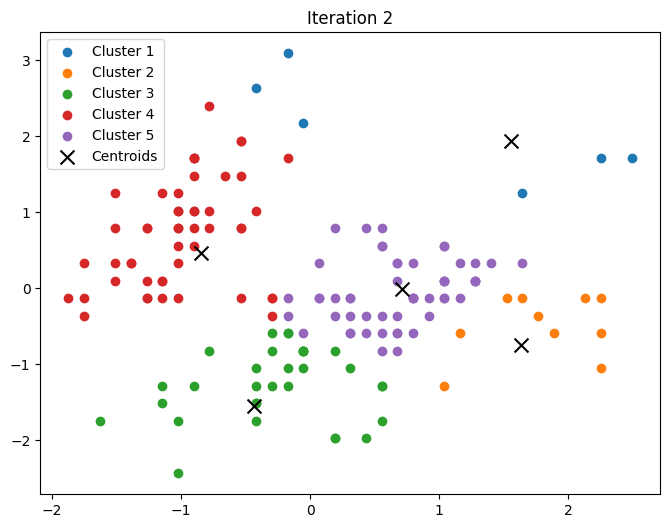

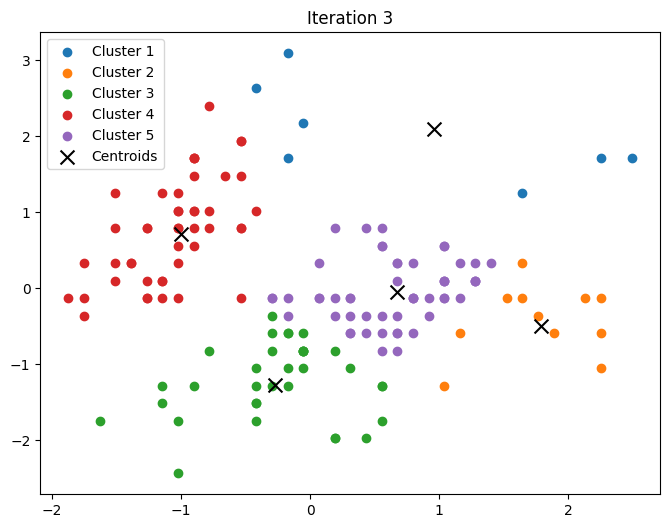

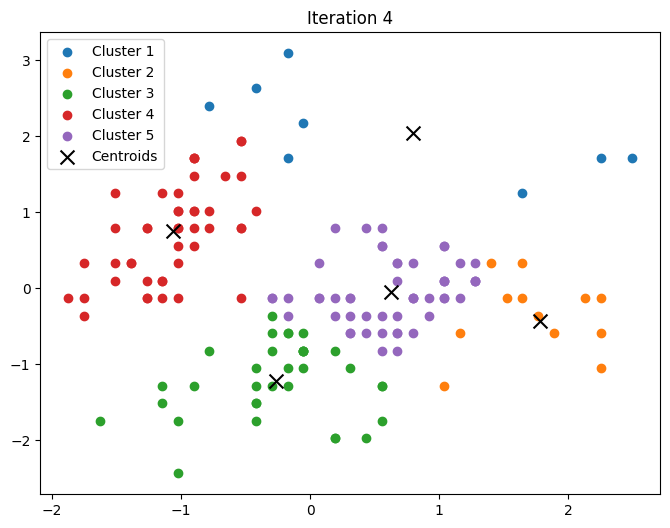

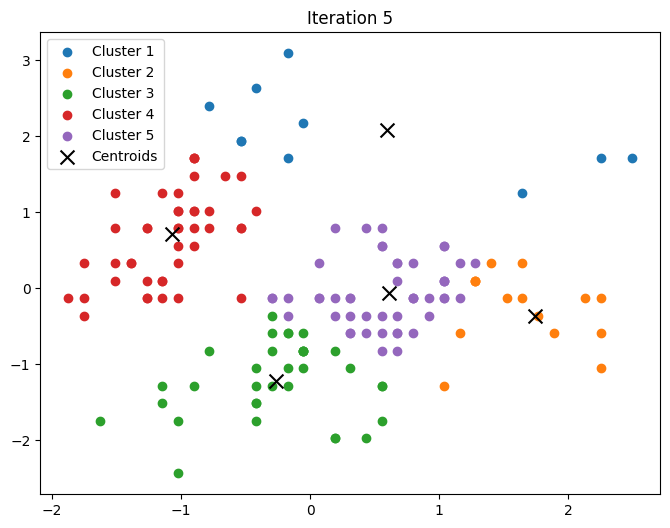

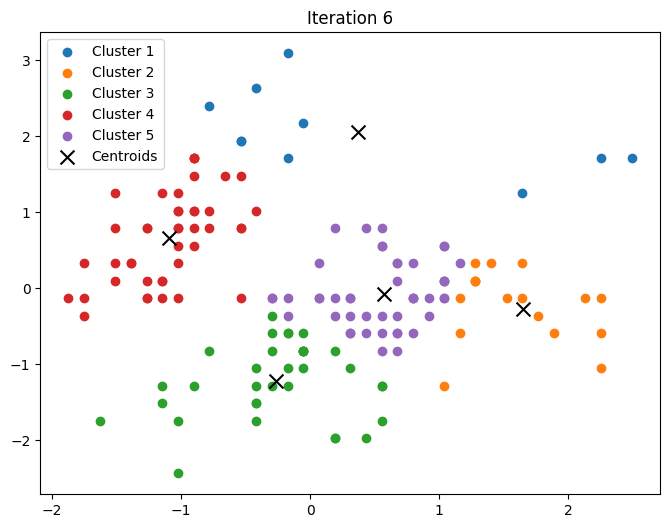

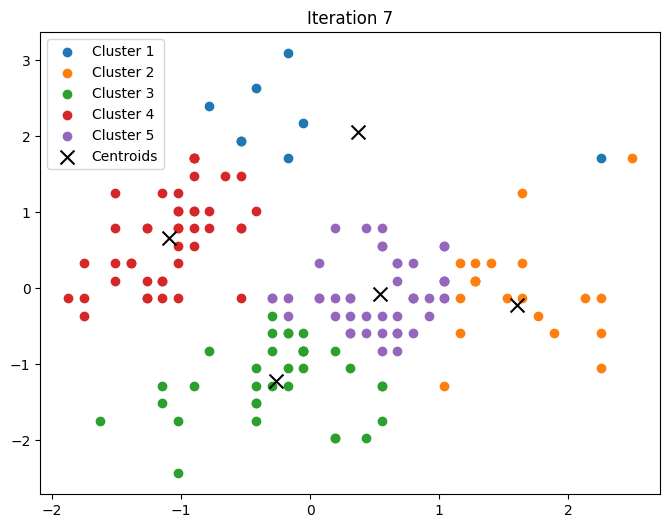

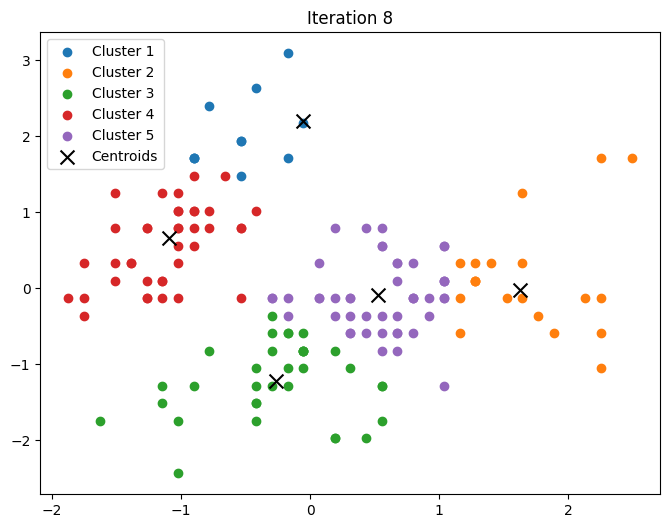

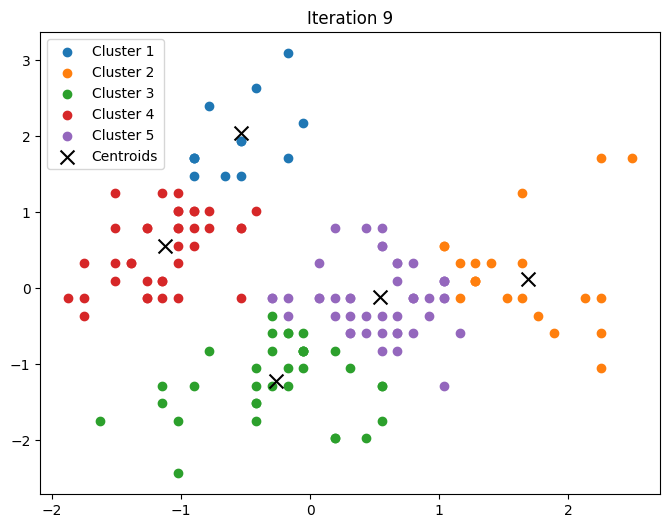

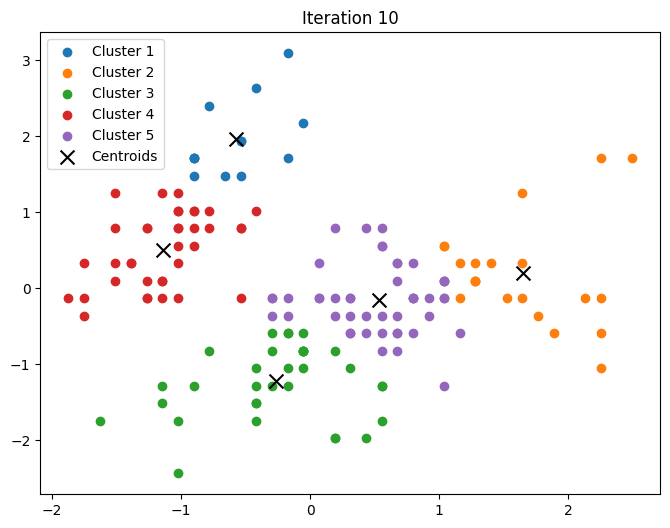

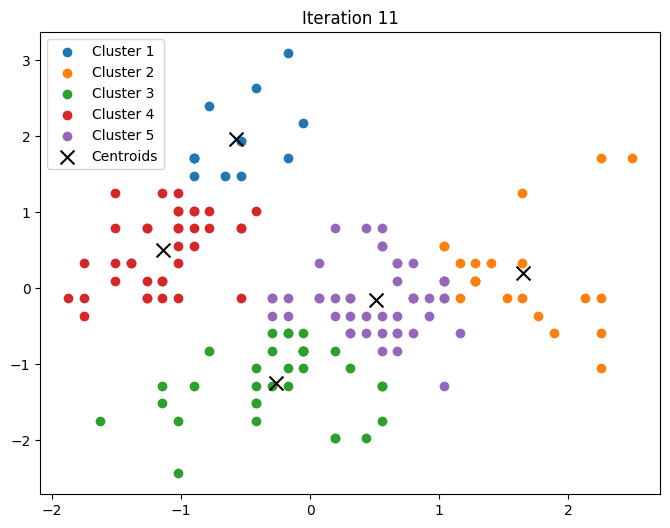

Converged at iteration 11
Average Inertia: 98.09496041250335
Accuracy: 0.7666666666666667


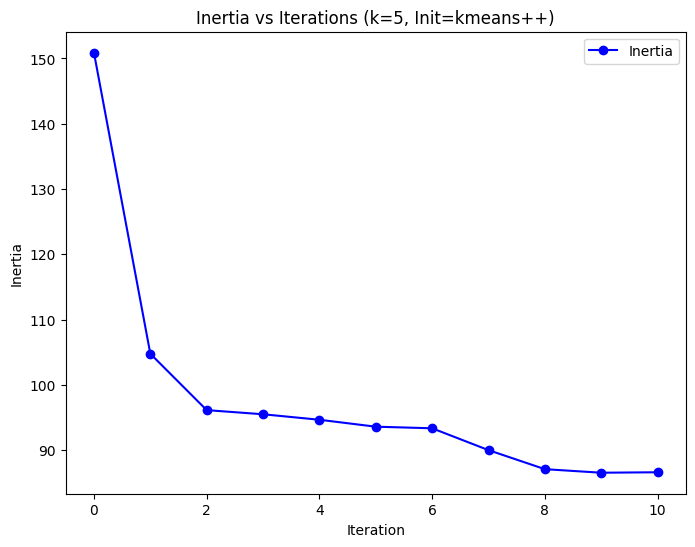

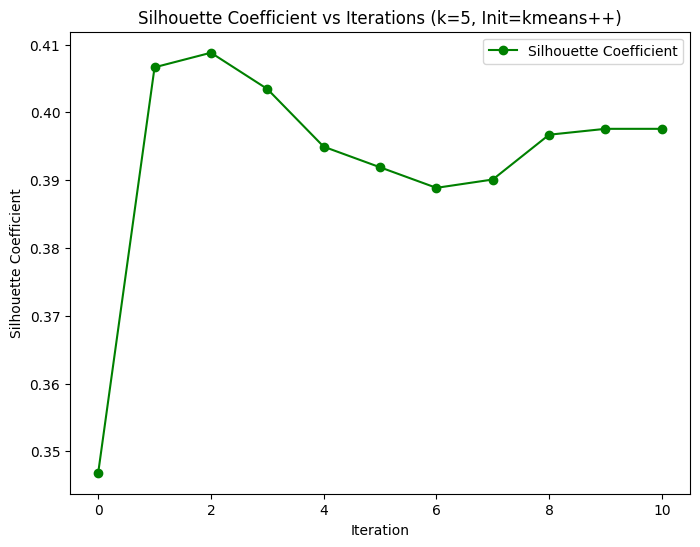

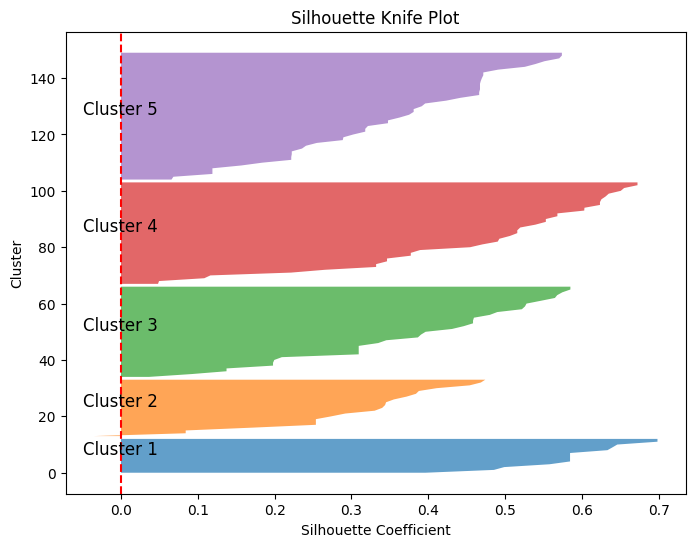

Final centroids:
[[-0.57445998  1.95749886]
 [ 1.64961401  0.19687304]
 [-0.26179604 -1.24808501]
 [-1.1397421   0.50883855]
 [ 0.51382201 -0.15700087]]
Inertia over iterations: [150.86899445835286, 104.7639104684832, 96.12452221677944, 95.4897365836529, 94.64956296076036, 93.58611292180856, 93.34339896740794, 89.99612610241876, 87.07920403395272, 86.536161839643, 86.6068339842771]
Final Silhouette Score: 0.39757302095460406


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

#Loading the Iris Dataset and only taking the first two features which are sepal length and speal width.
def load_data(dataset='iris'):
    if dataset == 'iris':
        data = datasets.load_iris()
        X = data.data[:, :2]
        y = data.target
    #loading the penguins dataset using only the first two features which are bill length and bill dpeth.
    elif dataset == 'penguins':
        url = "https://github.com/mbrudd/csci290/raw/refs/heads/main/data/penguins.csv"
        penguins = pd.read_csv(url)
        penguins = penguins.dropna()
        X = penguins[['bill_length_mm', 'bill_depth_mm']].values
        y = penguins['species'].values

       #take the species name and turns them into 0s 1s and 2s using a dictionary to pair the names and numbers.
        label_encoder = {label: idx for idx, label in enumerate(np.unique(y))}
        y = np.array([label_encoder[label] for label in y])

    return X, y

#scaling the data where x is the input data
def scale_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled


#this function is getting random points in case the selection method is random
def random_init(X, k):
    random_indices = np.random.choice(X.shape[0], size=k, replace=False)
    return X[random_indices]

#this function sets up the system to pick cordinates by hand.
def manual_init(X, k):
    print(f" Enter the {k} initial centroid coordinates. Separate with a space")
    centroids = []
    for i in range(k):
      #get the cords and converts the strings into numbers
        print(f"Enter coordinates for centroid {i+1} (5.1 3.5)")
        cords = input(f"Centroid {i+1}: ").strip().split()
        cords = [float(x) for x in cords]
        centroids.append(cords)
    return np.array(centroids)

# function to get the fancy pants kmeans from the book. not sure if I did this right.
def kmeans_plus_init(X, k):
    centroids = []
    #select a random point
    centroids.append(X[np.random.choice(X.shape[0])])
    # goes throuh k-1 times to find the remaining centroids
    for _ in range(1, k):
        # get the squared distance from each point to the nearest centroid then finds the min.
        dist_sq = np.min([euclidean_distance(X, centroid) for centroid in centroids], axis=0) ** 2
        #calculates the prob dist for the next centroid which is proportional to its squared distance from the nearsst centroid.
        prob_dist = dist_sq / np.sum(dist_sq)
        #new centroid is chosen at random from data based on the prob dist
        next_centroid_idx = np.random.choice(X.shape[0], p=prob_dist)
        #add point ot the centroid list.
        centroids.append(X[next_centroid_idx])

    return np.array(centroids)

# Euclidean distance function
def euclidean_distance(X, centroids):
    return np.sqrt(np.sum((X - centroids) ** 2, axis=1))

# plotting origional graph to make it easier to select points manually. This isnt really needed I dont think but it helps me.
def plot_initial_graph(X, title="Original Data"):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='blue', marker='o', label='Data Points')
    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()

# k means with a max iterations of 100 and a tol of 0.0001. if it moves less than that then it basically didnt move at all.
def kmeans(X, k, init_method='random', max_iter=100, tol=0.0001):
  #calls the different methods to get inital points based on the input.
    if init_method == 'random':
        centroids = random_init(X, k)
    elif init_method == 'manual':
        centroids = manual_init(X, k)
        if centroids is None:
            return None, None, None, None, None  # Return None if manual init fails
    elif init_method == 'kmeans++':
        centroids = kmeans_plus_init(X, k)
#creates an array that mirrors the centroids but is filled with 0s
    prev_centroids = np.zeros_like(centroids)
    #creates a mirriored array filled with zeros for X or the inputs
    labels = np.zeros(X.shape[0])
    inertia = []
    silhouette_scores = []

    # To store all iterations for plotting
    all_centroids = []

    for i in range(max_iter):
#get the euclidean distace between the points x and the centroids. the .T is flipping the rows and columns
        distances = np.array([euclidean_distance(X, centroid) for centroid in centroids]).T
        #assign each data point to the cluster it belongs to
        labels = np.argmin(distances, axis=1)

      #update the centroids by getting the mean of all data points assigned to each cluster.
        new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(k)])

        #get the inertia with sum of squared differences to nearest centroid
        current_inertia = np.sum(np.min(distances, axis=1))
        inertia.append(current_inertia)

       # calls the silhouette function and add them to list
        silhouette_score_value = calculate_silhouette(X, labels, centroids)
        silhouette_scores.append(silhouette_score_value)

       #creates the scatter plot
        plt.figure(figsize=(8, 6))
        for j in range(k):
            plt.scatter(X[labels == j, 0], X[labels == j, 1], label=f'Cluster {j+1}')
        plt.scatter(centroids[:, 0], centroids[:, 1], color='black', marker='x', s=100, label='Centroids')
        plt.title(f"Iteration {i+1}")
        plt.legend()
        plt.show()

        #checks to see if all the centroids change significantyl or not by comparing to the tolerance
        if np.all(np.abs(new_centroids - centroids) < tol):
            print(f"Converged at iteration {i+1}")
            break

        # Update centroids
        centroids = new_centroids
        all_centroids.append(centroids)

    return labels, centroids, inertia, silhouette_scores, all_centroids

# I had to look a lot of this up becasue i was confused so I'm not sure how right this is.
def calculate_silhouette(X, labels, centroids):
    #get the number of samples
    n_samples = X.shape[0]
    #make an empty array
    silhouette_scores = np.zeros(n_samples)
#loop through each data point
    for i in range(n_samples):
    # get the cluster labels assigned earlier
        cluster_label = labels[i]

        #creating a mask to select all datapoints in the same cluster as the current point.
        same_cluster_mask = (labels == cluster_label)
        #calc the average distance between current data point and all other ppints in the same cluster using euclidean distance
        a_i = np.mean(euclidean_distance(X[same_cluster_mask], X[i:i+1]))

        #creating a list of all cluster labels except the one of the current data point.
        other_cluster_labels = [l for l in range(centroids.shape[0]) if l != cluster_label]
        #gets the average distance between current data ppoint and all the points in the nearest neighboring cluster, then finds the min avergae distance among all other clusters.
        b_i = np.min([np.mean(euclidean_distance(X[labels == l], X[i:i+1])) for l in other_cluster_labels])

#actually calculating the silhouette coefficient
        silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i)

    # Return the average silhouette score over all points
    return np.mean(silhouette_scores)

# Function to calculate the accuracy of the clustering
def calculate_accuracy(true_labels, cluster_labels, k):
    cluster_to_label = {}
    for i in range(k):
      #identify the points belonging to that cluster using mask and gets their true labels.
      #finds the most frequent true label in the cluster
        cluster_mask = (cluster_labels == i)
        cluster_true_labels = true_labels[cluster_mask]

        # Manually find the most common label (mode)
        #finds the unique elements in cluster_true_labels. Return counts = True also counts the number of times those labels show up.
        unique_labels, counts = np.unique(cluster_true_labels, return_counts=True)
        #find the index of the max val in counts which is finding the most frequent label.
        most_common_label = unique_labels[np.argmax(counts)]
        #assigns most common label to the current cluster
        cluster_to_label[i] = most_common_label
    #iterates through cluster_label and uses cluster_to_label mapping to get true labels for each predicted cluster
    predicted_labels = np.array([cluster_to_label[label] for label in cluster_labels])
    #calc the accuracy for clustering. creates a boolean array where true is correct and false is incorrect.
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

# I really really really have no idea what is going on in this.
#I might as well not even include this becasue I dont know whats going on or how this works and I got most of this online so
#its basically not even really my work at this point but its here so i can say i tried i suppose.
def plot_silhouette_knife(X, labels, k):
  #an array to store silhouette coeficients for each data point in x. all initialized with 0.
    silhouette_vals = np.zeros(X.shape[0])

    for i in range(X.shape[0]):
        # Get the cluster label for the current point
        cluster_label = labels[i]

       #calc the average distance between the current point and all other points in the same cluster.
        same_cluster_mask = (labels == cluster_label)
        a_i = np.mean(euclidean_distance(X[same_cluster_mask], X[i:i+1]))

    #calc average distance between the current point and all points in the nearest enighboring cluster.
        other_cluster_labels = [l for l in range(k) if l != cluster_label]
        b_i = np.min([np.mean(euclidean_distance(X[labels == l], X[i:i+1])) for l in other_cluster_labels])

        # Calculate the silhouette score for the current point
        silhouette_vals[i] = (b_i - a_i) / max(a_i, b_i)

    fig, ax = plt.subplots(figsize=(8, 6))
    y_lower = 0
    for i in range(k):
        # get al the silhpuette vals for data in the current cluster and then sort
        cluster_silhouette_vals = silhouette_vals[labels == i]
        cluster_silhouette_vals.sort()
        # find the vertical max of the silhouette plot
        y_upper = y_lower + len(cluster_silhouette_vals)
        #create a horizontal silhouette plot for the cluster and shades the area between the coefficients for each plot in the cluster.
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, alpha=0.7)
        #adds label fore the curent cluster on the left
        ax.text(-0.05, (y_lower + y_upper) / 2, f'Cluster {i+1}', fontsize=12)

        y_lower = y_upper
#label graph
    ax.set_title("Silhouette Knife Plot")
    ax.set_xlabel("Silhouette Coefficient")
    ax.set_ylabel("Cluster")
    plt.show()



# Main function to run KMeans
def run_kmeans(dataset='iris', k=3, init_method='random'):
    # Load and scale data
    X, y = load_data(dataset)
    X_scaled = scale_data(X)

    # Plot the initial graph. again just for my sake becasue it helps me make manual points.
    plot_initial_graph(X_scaled, title="Original Data (No Centroids)")

    # Run K-Means
    labels, centroids, inertia, silhouette_scores, all_centroids = kmeans(X_scaled, k, init_method)

    # Calculate average inertia
    average_inertia = np.mean(inertia)
    print(f"Average Inertia: {average_inertia}")

    # Calculate accuracy
    accuracy = calculate_accuracy(y, labels, k)
    print(f"Accuracy: {accuracy}")

    # Plot Inertia graph
    plt.figure(figsize=(8, 6))
    plt.plot(inertia, marker='o', color='blue', label="Inertia")
    plt.title(f"Inertia vs Iterations (k={k}, Init={init_method})")
    plt.xlabel("Iteration")
    plt.ylabel("Inertia")
    plt.legend()
    plt.show()

    # Plot Silhouette Coefficient graph
    plt.figure(figsize=(8, 6))
    plt.plot(silhouette_scores, marker='o', color='green', label="Silhouette Coefficient")
    plt.title(f"Silhouette Coefficient vs Iterations (k={k}, Init={init_method})")
    plt.xlabel("Iteration")
    plt.ylabel("Silhouette Coefficient")
    plt.legend()
    plt.show()

    # Plot Silhouette Knife graph
    plot_silhouette_knife(X_scaled, labels, k)

    # Print final results
    print(f"Final centroids:\n{centroids}")
    print(f"Inertia over iterations: {inertia}")
    print(f"Final Silhouette Score: {silhouette_scores[-1]}")

# Run the program
run_kmeans(dataset='iris', k=5, init_method='kmeans++')
